In [1]:
import numpy as np
import random
random.seed(0)

methods = ['againvc', 'freevc', 'medium', 'styletts', 'triaan', 'vqmivc', 'knnvc', 'sigvc', 'bne_ppg_vc', 'diffvc', 's2vc', 'yourtts']
methods_train =  ['againvc', 'freevc', 'medium', 'styletts', 'triaan', 'vqmivc', 'knnvc', 'sigvc']

train_centers = []
embd_10_all = []

for method in methods_train:
    all_embd = []
    embds = np.load('exp/8vc_method/%s_tra_cla_24.npy' % (method), allow_pickle=True).item()
    for key in embds.keys():
        all_embd.append(embds[key][0])
    counts = len(all_embd)
    split_1 = int(counts//10)
    random.shuffle(all_embd) # 随机打乱
    embd_10 = all_embd[:split_1]
    embd_10_all.append(embd_10)
    embd_90 = all_embd[split_1:]
    column_means = [sum(col) / len(col) for col in zip(*embd_90)]
    train_centers.append(column_means)
# print(train_centers)

[[17.710774542385842, -20.415635911169183, -16.320388829116986, -22.109414367101003, -13.975911771565405, -21.94554981153543, -21.015661306764635, -39.9696441936163], [-14.890475236556558, 14.595692792138296, -18.907602610591066, -25.10039959621224, -17.0224817940165, -26.11973381012072, -15.813923670454189, -29.681426508839404], [-11.782472874701504, -17.18745586226739, 13.472943116181423, -18.904922668455388, -12.689543520626097, -19.727528652149708, -14.103679166114624, -31.0152778036689], [-20.822855926888966, -21.52711821612731, -23.188634323971563, 19.2069532651795, -17.553734515414586, -28.3896531223937, -16.336983533231948, -31.234598050127456], [-26.592405813154798, -21.497453601557726, -24.949207294966868, -29.084998824701046, 12.525623433592337, -13.256628983287449, -24.81343871974838, -34.12064964224026], [-25.324174522146315, -22.475056710200565, -24.338944625596294, -26.180310492120842, -9.338149503727353, 15.297010005994816, -20.4244943102902, -37.05844134533194], [-15.1

In [3]:
import multiprocessing
import math
import heapq

def euclidean_distance(point1, point2):
    # 计算两个点之间的差异平方和
    squared_diff = sum((p - q) ** 2 for p, q in zip(point1, point2))
    # 取平方和的平方根，即为欧式距离
    distance = math.sqrt(squared_diff)
    return distance

def worker(start, end, shared_dict):
    """工作函数"""
    th_avg = {}
    for th in range(start,end,1):
        th = th/100
        acc_all = []
        for i in range(len(embd_10_all)):
            embds = embd_10_all[i]
            t = 0
            f = 0
            for j in range(len(embds)):
                tmp = []
                for k in range(len(methods_train)):
                    tmp.append(euclidean_distance(embds[j], train_centers[k]))
                min_1, min_2 = heapq.nsmallest(2, enumerate(tmp), key=lambda x: x[1])
                if min_1[1] / min_2[1] <= th:
                    if min_1[0] == i:
                        t += 1
                    else:
                        f += 1
                else:
                    f += 1
            acc = t/(t+f)
            acc_all.append(acc)
        th_avg[th] = acc_all
    # 将本地字典写入共享字典
    shared_dict.update(th_avg)


num_processes = 20
tasks_per_process = 5

# 创建共享字典
manager = multiprocessing.Manager()
shared_dict = manager.dict()

# 创建进程池
pool = multiprocessing.Pool(processes=num_processes)

# 执行工作函数
for i in range(num_processes):
    start = i * tasks_per_process + 1
    end = start + tasks_per_process + 1
    pool.apply_async(worker, args=(start, end, shared_dict))

# 关闭进程池
pool.close()
pool.join()

# 输出共享字典内容
print("合并后的字典：", shared_dict)

合并后的字典： {0.31: [0.9422771672771673, 0.9951459274636708, 0.9946275946275946, 0.9872687305367284, 0.9655067155067155, 0.9484259061345385, 0.9793446424212838, 0.9900488400488401], 0.32: [0.9454822954822955, 0.9963365490291854, 0.9956349206349207, 0.9890700372473591, 0.971001221001221, 0.9535252984823964, 0.9829753478154747, 0.9914529914529915], 0.33: [0.9477106227106227, 0.9970387104652583, 0.9965201465201465, 0.9903217927581364, 0.9747863247863248, 0.9584414791291337, 0.9853551379057848, 0.9926434676434677], 0.34: [0.9496031746031746, 0.9977714006594212, 0.9971306471306471, 0.9917262013799841, 0.9788156288156288, 0.962777489388989, 0.9877349279960947, 0.9935286935286936], 0.35: [0.9512820512820512, 0.9981988032726828, 0.9975885225885226, 0.9931000793796178, 0.9821428571428571, 0.967021893798284, 0.9894740053697828, 0.9943833943833944], 0.36: [0.9527472527472527, 0.998473562095494, 0.997954822954823, 0.9941075899126824, 0.9852564102564103, 0.9706250572536566, 0.9910910422260191, 0.9952686

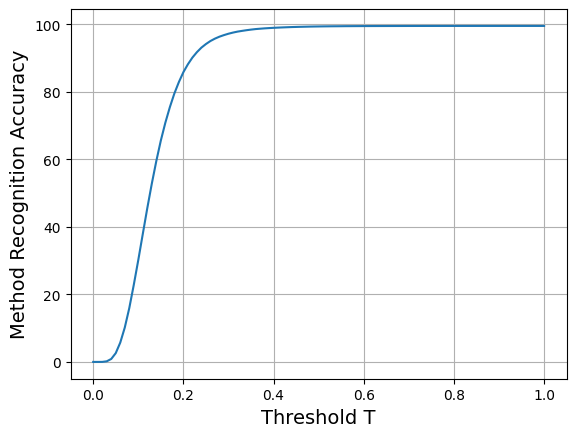

In [4]:
import matplotlib.pyplot as plt

# 生成数据
x = [i/100 for i in range(0,101,1)]
y = [i for i in range(0,101,1)]


for i in range(1,101,1):
    y[i] = sum(shared_dict[i/100])/8 * 100
    
    
# 绘制曲线图
plt.plot(x, y)
plt.xlabel('Threshold T', fontsize=14)
plt.ylabel('Method Recognition Accuracy', fontsize=14)
plt.grid(True)
plt.show()


In [5]:
for idx, method in enumerate(methods):
    label = []
    t = 0
    f = 0
    embds = np.load('exp/8vc_method/%s_cla_24.npy' % (method), allow_pickle=True).item()
    for key in embds.keys():
        tmp = []
        for i in range(len(methods_train)):
            tmp.append(euclidean_distance(embds[key][0], train_centers[i]))
        min_1, min_2 = heapq.nsmallest(2, enumerate(tmp), key=lambda x: x[1])
        if idx < 8:
            if min_1[1] / min_2[1] <= 0.4:
                if min_1[0] == idx:
                    t += 1
                else:
                    f += 1
            else:
                f += 1
        else:
            if min_1[1] / min_2[1] <= 0.4:
                f += 1
            else:
                t += 1
    print(t/(t+f))

0.9744221036793872
0.9991109287375188
0.9969224456298728
0.997811516892354
0.9848857885378197
0.9127342360826153
0.9954862535904802
0.9875530023252633
0.9980850772808098
0.9976747366981261
0.996648885241417
0.9739433729995897
